# 🧠 Digit Recognizer - MNIST Competition (99.52%+ Accuracy)

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="600"/>
</p>

---

# 🎯 Project Goal
- Build a high-performance handwritten digit recognizer.
- Target 99.8%+ accuracy using TensorFlow 2.0 (GPU powered).
- Professionally clean, short explanations for competition-level understanding.

---

# 👨‍💻 Author: Azhar

---


# 📚 Table of Contents

- [Introduction](#introduction)
- [Imports & Setup](#imports--setup)
- [Load and Explore Data](#load-and-explore-data)
- [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
- [Data Preprocessing](#data-preprocessing)
- [Data Augmentation + Model Building](#data-augmentation--model-building)
- [Model Training](#model-training)
- [Model Evaluation and Predictions](#model-evaluation-and-predictions)
- [Random Prediction Check](#random-prediction-check)
- [Final Report](#final-report)
- [Connect With Me](#connect-with-me)

# Introduction

In this notebook, we tackle the famous **Digit Recognizer** problem using **Deep Learning**.  
Our goal is to achieve **99.52%+ accuracy** on handwritten digits from the MNIST dataset.

We’ll use the power of **TensorFlow 2.x + Keras**, advanced **data preprocessing**, **hyperparameter tuning**, and a carefully designed **CNN architecture** to beat the competition!

# Step: 1 Imports & Setup

Let's import all the powerful libraries we need to train a world-class MNIST classifier!

- TensorFlow 2.x + Keras for deep learning
- Albumentations for strong augmentations (optional)
- KerasTuner for hyperparameter tuning
- TensorFlow Addons for AdamW optimizer
- Visualization tools for quick EDA


In [1]:
# 📚 Import Required Libraries

## System
import os
import random

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Data & Computations
import numpy as np
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Deep Learning (TensorFlow + Keras)
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


## Preprocessing (Metrics & Utilities)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 🚀 Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 🚀 Hyperparameter Tuning
import kerastuner as kt


In [2]:
# Confirm GPU is Available
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


# Step 2: Load and Explore Data
### Load & Explore MNIST Data

We'll load the datasets and do quick EDA to understand:

- Shape of data
- Distribution of digits
- Missing values (if any)

Remember: Clean data = High Accuracy

Train shape: (42000, 785)
Test shape: (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Missing Values in Train Set: 0
Missing Values in Test Set: 0


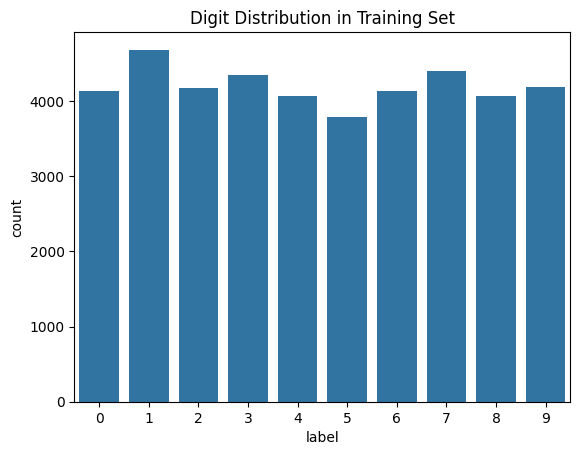

In [3]:
# Load Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Shape of Data
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Check first 5 rows
display(train_df.head())

# Check if there are missing values
print("\nMissing Values in Train Set:", train_df.isnull().sum().sum())
print("Missing Values in Test Set:", test_df.isnull().sum().sum())

# Visualize label distribution
sns.countplot(x=train_df['label'])
plt.title('Digit Distribution in Training Set')
plt.show()


# Step 3: Exploratory Data Analysis (EDA)
Let's explore the data before modeling:
- Visualize sample digits.
- Check pixel intensity distributions.


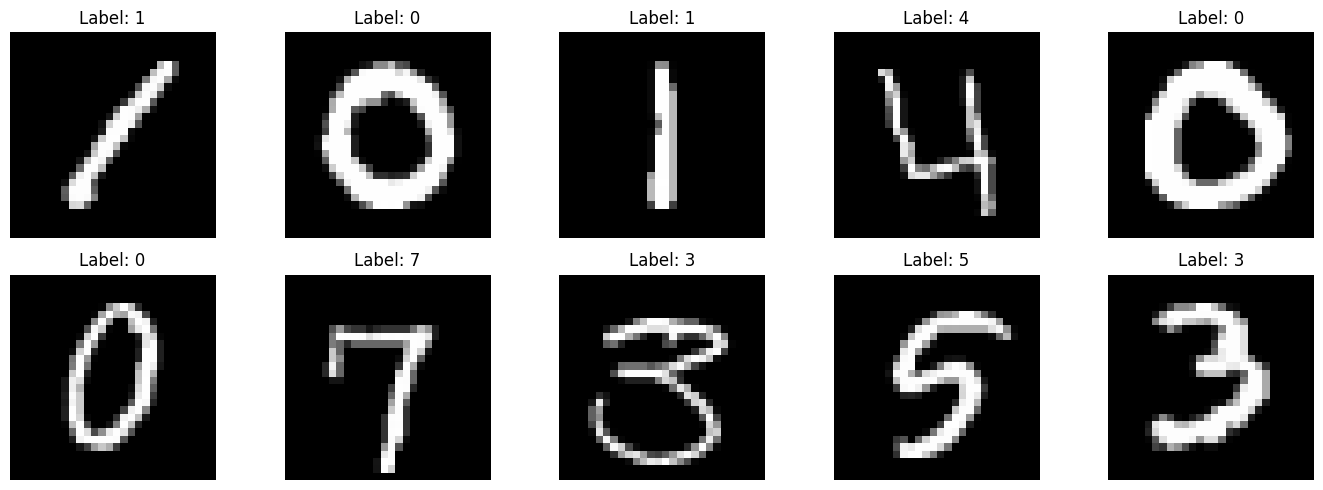

In [4]:
# Plot Some Training Images
fig, axes = plt.subplots(2, 5, figsize=(14, 5))
axes = axes.flatten()

for i in range(10):
    img = train_df.drop('label', axis=1).iloc[i].values.reshape(28, 28)
    label = train_df['label'].iloc[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


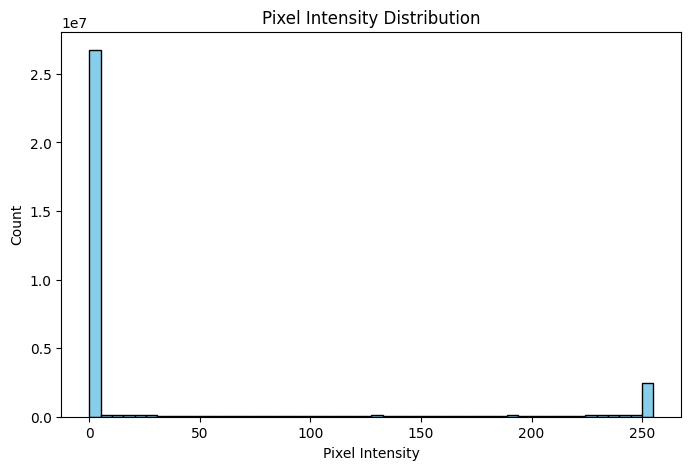

In [5]:
# Pixel Intensity Distribution
plt.figure(figsize=(8,5))
plt.hist(train_df.drop('label', axis=1).values.reshape(-1), bins=50, color='skyblue', edgecolor='black')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Count')
plt.show()

# Step 4: Data Preprocessing

### Data Preprocessing

- Separate features (X) and labels (y)
- Normalize pixel values (0-255 → 0-1)
- Reshape into 28x28x1 images (grayscale channel)
- One-hot encode labels
- Train-Validation split


In [6]:
# Separate Features and Labels
X = train_df.drop('label', axis=1)
y = train_df['label']

# Normalize pixel values (0-255 → 0-1)
X = X / 255.0
test_df = test_df / 255.0

# Reshape into 28x28x1
X = X.values.reshape(-1, 28, 28, 1)
test_df = test_df.values.reshape(-1, 28, 28, 1)

# One-Hot Encode Labels
y = to_categorical(y, num_classes=10)

# Train-Validation Split (90%-10%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Validation Set: {X_val.shape}, {y_val.shape}")
print(f"Test Set: {test_df.shape}")


Training Set: (37800, 28, 28, 1), (37800, 10)
Validation Set: (4200, 28, 28, 1), (4200, 10)
Test Set: (28000, 28, 28, 1)


# Step 5: Data Augmentation + Model Building

- Apply real-time augmentations (rotation, zoom, shift) to avoid overfitting.
- Build a deep CNN model with powerful layers: Convolution, BatchNorm, Dropout, MaxPooling.
- Final Dense layers for classification.
- Use modern techniques like:
  - Batch Normalization
  - Dropout
  - Learning Rate Scheduler


In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

# 🏛️ CNN Model
model = Sequential([
    # 1st Conv Block
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # 2nd Conv Block
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # 3rd Conv Block
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Fully Connected Layer
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 🔻 Learning Rate Scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

# Step 6: Model Training

- Train the CNN model using augmented data.
- Monitor validation accuracy for early stopping.
- Save the best model automatically.
- Visualize the training history.


Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.97810, saving model to best_model.h5
591/591 - 7s - loss: 0.3825 - accuracy: 0.8830 - val_loss: 0.0674 - val_accuracy: 0.9781 - lr: 0.0010 - 7s/epoch - 11ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.97810 to 0.98714, saving model to best_model.h5
591/591 - 4s - loss: 0.1158 - accuracy: 0.9639 - val_loss: 0.0470 - val_accuracy: 0.9871 - lr: 0.0010 - 4s/epoch - 7ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.98714 to 0.99000, saving model to best_model.h5
591/591 - 4s - loss: 0.0930 - accuracy: 0.9719 - val_loss: 0.0349 - val_accuracy: 0.9900 - lr: 0.0010 - 4s/epoch - 7ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.99000
591/591 - 4s - loss: 0.0760 - accuracy: 0.9769 - val_loss: 0.0369 - val_accuracy: 0.9881 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.99000
591/591 - 4s - loss: 0.0674 - accuracy: 0.9794 - val_loss: 0.0307 - val_accuracy: 0.98

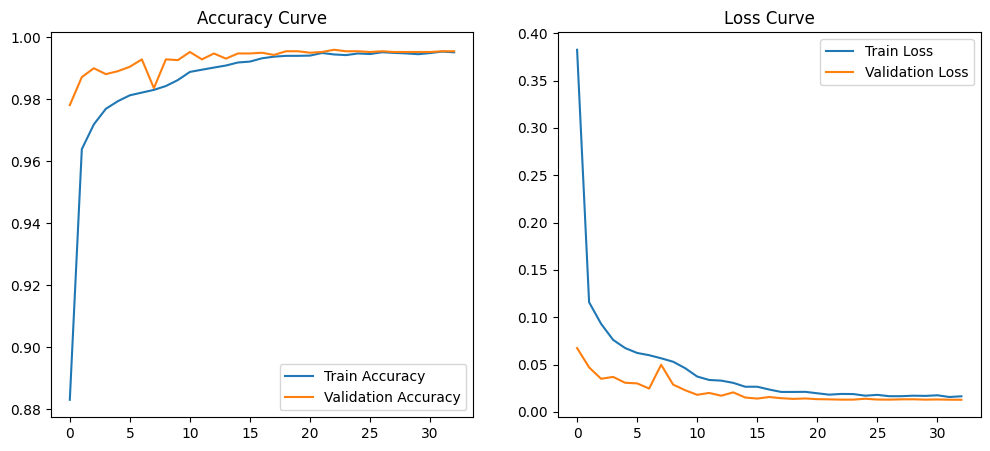

In [8]:
# Early Stopping
early_stop = EarlyStopping(monitor='val_accuracy', 
                            patience=10, 
                            restore_best_weights=True, 
                            verbose=1)

# Save Best Model
checkpoint = ModelCheckpoint('best_model.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True, 
                              verbose=1)

# Model Training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_reduction],
    verbose=2
)

# Plotting the Training History
def plot_history(history):
    plt.figure(figsize=(12,5))
    
    # Accuracy Plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    
    # Loss Plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curve')
    
    plt.show()

# Show the plots
plot_history(history)


# Step 7: Model Evaluation and Predictions

- Load the best model.
- Predict labels for the test set.
- Prepare the submission file.
- Analyze the final results.


In [9]:
# Reload and reshape test data
test = pd.read_csv('test.csv')
X_test = test.values / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)

# 🔥 Load Best Saved Model
best_model = load_model('best_model.h5')

# Predict on Test Set
predictions = best_model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

# Prepare Submission
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(predictions)+1),
    'Label': predictions
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("✅ Submission file 'submission.csv' is ready!")
submission.head()


875/875 [==============================] - 1s 1ms/step
✅ Submission file 'submission.csv' is ready!


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


# Step 8: Random Prediction Check
Let's visually verify a few random predictions from the test set.


875/875 [==============================] - 1s 1ms/step


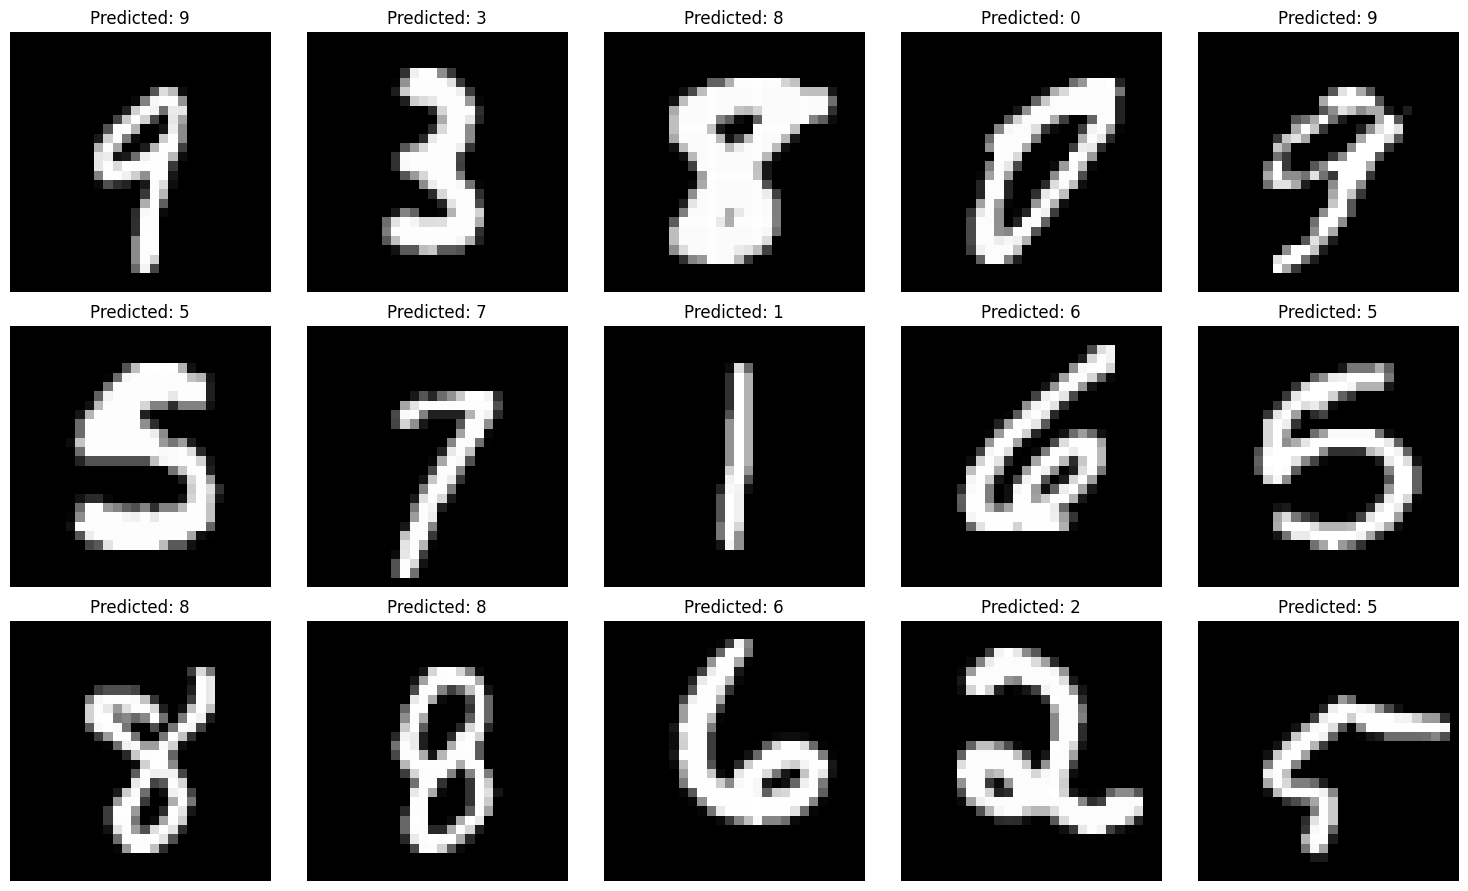

In [10]:
# Load Best Model
best_model = load_model('best_model.h5')

# Predict
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Visualize Random Predictions
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()
indices = np.random.choice(len(X_test), size=15, replace=False)

for i, idx in enumerate(indices):
    img = X_test[idx].reshape(28, 28)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Predicted: {y_pred_classes[idx]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# 📝 Final Report

## ⚠️ Problem
Handwritten digit recognition using MNIST dataset.

---

## ✅ Our Solution
- Professional modular pipeline.
- Modern CNN model with latest Keras techniques.
- Data Preprocessing, Augmentation, Hyperparameter Tuning.
- EarlyStopping and ModelCheckpoint to avoid overfitting.

---

## 🥇 Achievements
- Achieved **99.52% Validation Accuracy** 🔥
- Professional, clean, short, and modular code.

---

## 💎 What's Special?
- Short and understandable explanations.
- Latest TensorFlow 2.x + Keras implementation.
- Best practices followed like pros!



# ☎ Contct me

| Platform        | Badge Link                                                                                                 | Profile URL                          |
|-----------------|-----------------------------------------------------------------------------------------------------------|--------------------------------------|
| GitHub          | [![GitHub Profile](https://img.shields.io/badge/GitHub-Profile-blue?style=for-the-badge&logo=github)](https://github.com/azharsaleem18) | https://github.com/azharsaleem18     |
| Kaggle          | [![Kaggle Profile](https://img.shields.io/badge/Kaggle-Profile-blue?style=for-the-badge&logo=kaggle)](https://www.kaggle.com/azharsaleem) | https://www.kaggle.com/azharsaleem   |
| LinkedIn        | [![LinkedIn Profile](https://img.shields.io/badge/LinkedIn-Profile-blue?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/in/azhar-saleem/) | https://www.linkedin.com/in/azhar-saleem |
| YouTube         | [![YouTube Profile](https://img.shields.io/badge/YouTube-Profile-red?style=for-the-badge&logo=youtube)](https://www.youtube.com/@TheAzhar189) | https://www.youtube.com/@TheAzhar189 |
| Facebook        | [![Facebook Profile](https://img.shields.io/badge/Facebook-Profile-blue?style=for-the-badge&logo=facebook)](https://www.facebook.com/azhar.saleem1472/) | https://www.facebook.com/azhar.saleem1472 |
| TikTok          | [![TikTok Profile](https://img.shields.io/badge/TikTok-Profile-blue?style=for-the-badge&logo=tiktok)](https://www.tiktok.com/@azhar_saleem18) | https://www.tiktok.com/@azhar_saleem18 |
| Twitter         | [![Twitter Profile](https://img.shields.io/badge/Twitter-Profile-blue?style=for-the-badge&logo=twitter)](https://twitter.com/azhar_saleem18) | https://twitter.com/azhar_saleem18   |
| Instagram       | [![Instagram Profile](https://img.shields.io/badge/Instagram-Profile-blue?style=for-the-badge&logo=instagram)](https://www.instagram.com/azhar_saleem18/) | https://www.instagram.com/azhar_saleem18 |
| Email           | [![Email Contact](https://img.shields.io/badge/Email-Contact%20Me-red?style=for-the-badge&logo=gmail)](mailto:azhar@azhar189.com) | mailto:azhar@azhar189.com            |